In [24]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np
import ast
from Bio import SeqIO
from Bio.SeqFeature import SeqFeature, FeatureLocation, CompoundLocation
from itertools import groupby
from operator import itemgetter

In [2]:
def readin_virus_config(virus):
    """
    Read in the config file for this virus to get the paths to alignment, metadata files, etc 
    as well as metadata about the virus such as how many subtypes, 
    and which genes are receptor-binding or polymerase
    """
    config_json = f'config/adaptive_evo_config_{virus}.json'
    with open(config_json) as json_handle:
        configs = json.load(json_handle)
        
    return configs

In [3]:
def get_sequence_counts(legible_name, virus, subtype, gene, window, min_seqs, in_analysis=True, year_max=None, year_min=None):
    
    """
    Read in the alignment and metadata files for the specified virus and subtype, as would be done by the analysis
    And just get a count of how many sequences are available for each year
    """
    
    configs = readin_virus_config(virus)
    
    #some dengue files are shared between all genotypes of the same serotype
    if virus=='dengue':
        serotype = subtype.split('_')[0]
    else:
        serotype = False
    
    subunit = False
    #find if gene is a subunit of surface protein
    if subtype==None:
        gene_location_key = "location"
    else:
        #dengue reference files and locations are shared among serotypes
        if serotype:
            gene_location_key = "location_"+str(serotype)
        else:
            gene_location_key = "location_"+str(subtype)
            
    if gene.upper() == configs['receptor_binding']['virus_gene'].upper():
        if "specify_location" in configs['receptor_binding'].keys():
            subunit = True
            parent_gene = configs['receptor_binding']['specify_location']['parent_gene']
            gene_location_list = ast.literal_eval(configs['receptor_binding']['specify_location'][gene_location_key])

        
    #Find reference, alignment and meta files (some sub-genic regions may use files from a gene or a whole genome)
    if subunit:
        alignment_file = configs['alignment_file'].format(virus=virus, subtype=subtype, gene=parent_gene)
        meta_file = configs['meta_file'].format(virus=virus, subtype=subtype, gene=parent_gene)
        #some are comma-separated, some are tab-separated
        metafile_sep = configs['metafile_sep']
    else:
        alignment_file = configs['alignment_file'].format(virus=virus, subtype=subtype, gene=gene)
        meta_file = configs['meta_file'].format(virus=virus, subtype=subtype, gene=gene)
        metafile_sep = configs['metafile_sep']
        #dengue reference files are shared among serotypes
        if serotype:
            reference_file = configs['reference_file'].format(virus=virus, subtype=serotype, gene=gene)
        else:
            reference_file = configs['reference_file'].format(virus=virus, subtype=subtype, gene=gene)
    

    
    # if a minimum year to use is supplied in config, limit seqs to this
    if 'min_year' in configs.keys():
        year_min = int(configs['min_year'])
    
    #Find gene location, if domain is sub-genic or reference file contains multiple genes
    gene_location = False
    #If domain is sub-genic, fetch its position (within genome or parent gene) from config file

    if subunit:
        #Need to deal with domains the are not contiguous
        if len(gene_location_list)==1:
            gene_location = SeqFeature(FeatureLocation(gene_location_list[0][0], gene_location_list[0][1]))
        else:
            compound_locations = []
            for location in gene_location_list:
                compound_locations.append(FeatureLocation(location[0], location[1]))
            gene_location = CompoundLocation(compound_locations)

    #for reference files where the gene is named differently
    #like for fluC, where the segment is NS, but it contains NS1 and NS2
    elif 'specify_locations' in configs.keys() and gene in configs['specify_locations'].keys():       
        gene_location_list = ast.literal_eval(configs['specify_locations'][gene])
        gene_location = SeqFeature(FeatureLocation(gene_location_list[0][0], gene_location_list[0][1]))

    #Find gene location from reference files
    else:
        for seq_record in SeqIO.parse(reference_file, "genbank"):
            for feature in seq_record.features:
                if feature.type == 'CDS':
                    if 'gene' in feature.qualifiers.keys():
                        if feature.qualifiers['gene'][0].lower() == gene.lower():
                            gene_location = feature.location
                    if gene_location==False:
                        if 'product' in feature.qualifiers.keys():
                            if feature.qualifiers['product'][0].lower() == gene.lower():
                                gene_location = feature.location
                    if gene_location == False:
                        if 'locus_tag' in feature.qualifiers.keys():
                            if feature.qualifiers['locus_tag'][0].lower() == gene.lower():
                                gene_location = feature.location  
                        

    #Subset data based on time windows
    meta = pd.read_csv(meta_file, sep = metafile_sep)
    #drop incomplete date data
    meta.drop(meta[meta['date']=='?'].index, inplace=True)
    meta = meta[meta["date"].str.contains("20XX")==False]
    meta = meta[meta["date"].str.contains("36-0")==False]
    meta.dropna(subset=['date'], inplace=True)
    meta['year'] = meta['date'].str[:4].astype('int')
    if year_max:
        meta.drop(meta[meta['year']>year_max].index, inplace=True)
    if year_min:
        meta.drop(meta[meta['year']<year_min].index, inplace=True)
    
    date_range = meta['year'].max() - meta['year'].min()
    #Remove egg- and cell-passaged strains
    meta.drop(meta[meta['strain'].str[-4:]=='-egg'].index, inplace=True)
    meta.drop(meta[meta['strain'].str[-5:]=='-cell'].index, inplace=True)
    
    #Limit meta data to only strains in alignment file
    aligned_isolates = []
    with open(alignment_file, "r") as aligned_handle:
        for isolate in SeqIO.parse(aligned_handle, "fasta"):
            aligned_isolates.append(isolate.id)
    aligned_isolates_df = pd.DataFrame(aligned_isolates, columns=['strain'])
    meta = meta.merge(aligned_isolates_df, on='strain', how='inner')
    
    
    # tally sequences per year
    seq_counts = meta.groupby('year').agg(seq_count=('strain', 'count')).reset_index()
    
    #Find the first time point used
    if in_analysis==True:
        intermediates_file = f'adaptation_results/intermediates/input_data_{virus}_{subtype}_{gene}_{window}_{min_seqs}_None_None.json'

        with open(intermediates_file) as json_handle:
            json_dict = json.load(json_handle)
            (aligned_codons_in_window, outgroup_codons, year_windows) = (json_dict['aligned_codons_in_window'], 
                                                                         json_dict['outgroup_codons'], 
                                                                         json_dict['year_windows'])

        first_year = int(year_windows[0].split('-')[0])

        # exclude sequences before the first year of the analyis
        seq_counts_years_used = seq_counts[seq_counts['year']>=first_year]
        
    # if analysis was not run on this virus, there will not be a "first timepoint"
    else:
        seq_counts_years_used = seq_counts
        
    # get all years for which there is a sequence count
    all_years = list(seq_counts_years_used['year'])
    
    # fill in empty years with 0 count so they will appear on plot
    all_years_filler = []
    for y in range(seq_counts_years_used['year'].min(), seq_counts_years_used['year'].max()):
        if y not in all_years:
            all_years_filler.append({'year': y, 'seq_count':0})    
    filler_df = pd.DataFrame(all_years_filler)
    
    # concat filler df with seq_counts df 
    seq_counts_years_used = pd.concat([seq_counts_years_used, filler_df], ignore_index=True)

        
    #add column wiht virus name
    seq_counts_years_used['virus'] = legible_name
   



    
    return seq_counts_years_used


In [4]:
all_viruses = ['h3n2', 'h1n1pdm','vic', 'yam', 'influenzaC', 
                    'measles', 'mumps', 'parainfluenza', 'rsv',
                    'oc43', '229e', 'nl63',
                    'dengue', 'rotavirusAg1p8', 'rotavirusAg1p4', 'norovirus',
                    'enterovirusd68', 'hepatitisA_IA',
                    'hepatitisB','parvovirusB19', 'adenovirusB7', 'adenovirusB3']

In [5]:
to_include = ['Influenza A/H3N2', 'Influenza A/H1N1pdm', 'Influenza B/Vic', 'Influenza B/Yam', 
                              'Influenza C/Yamagata', 'Measles', 'Mumps', 'Parainfluenza-1', 'Parainfluenza-3', 
                              'RSV-A', 'RSV-B', 
                              'OC43-A','229E', 'NL63', 
                              'Dengue 1-V', 'Dengue 2-AA', 'Dengue 3-III', 'Dengue 4-II', 
                               'Rotavirus A/P[8]', 'Rotavirus A/P[4]', 'Norovirus GII.4', 'Enterovirus D68', 
                              'Hepatitis A-IA', 'Parvovirus B19-1A', 
                              'Adenovirus B-7', 'Adenovirus B-3', 'Hepatitis B-A2', 'Hepatitis B-D3']

In [6]:
def get_seq_counts_all_viruses(viruses, to_include):
    """
    For each virus, get how many sequences there are in each time window to plot histogram
    """
    
    all_virus_seq_counts = pd.DataFrame()
    
    
    for virus in viruses:
        configs = readin_virus_config(virus)
            
        receptor_binding_gene = configs['receptor_binding']['virus_gene']
        #if virus has subtypes, want to get info for each subtype
        if configs['subtype']=='True':
            for subtype in configs['subtypes']:
                virus_and_subtype = f'{virus}_{subtype}'
                legible_name = configs['legible_name'][subtype]
                
                if legible_name in to_include:
                    seqs_per_year = get_sequence_counts(legible_name, virus, subtype, receptor_binding_gene, 5, 3)
                    all_virus_seq_counts = pd.concat([all_virus_seq_counts, seqs_per_year], ignore_index=True)
        else:
            subtype = None
            virus_and_subtype = f'{virus}_{subtype}'
            legible_name = configs['legible_name']
            if legible_name in to_include:
                if virus in ['h1n1pdm', 'mumps']:
                    seqs_per_year = get_sequence_counts(legible_name, virus, None, receptor_binding_gene, 3, 3)
                    all_virus_seq_counts = pd.concat([all_virus_seq_counts, seqs_per_year], ignore_index=True)
                else:
                    seqs_per_year = get_sequence_counts(legible_name, virus, None, receptor_binding_gene, 5, 3)
                    all_virus_seq_counts = pd.concat([all_virus_seq_counts, seqs_per_year], ignore_index=True)
                    
 
    df = all_virus_seq_counts
                
    return df
                
                

In [7]:
df = get_seq_counts_all_viruses(all_viruses, to_include)

In [8]:
all_viruses_legible = list(df['virus'].unique())

In [47]:
def plot_absolute_count(filename=False):
    """
    Plot the number of sequences in each year, and highlight each year where there is at least one sequence
    """
    
    # plot total count of sequences at timepoint
    # highlight years with at least one sequence

    # for each virus, find years with at least one sequence
    years_w_seq_by_virus = {}
    for v in all_viruses_legible:
        subdf = df[df['virus']==v]
        nonzero = subdf[subdf['seq_count']!=0]
        years_w_seqs = list(nonzero['year'].unique())
        # group consecutive years
        gb = groupby(enumerate(years_w_seqs), key=lambda x: x[0] - x[1])
        all_groups = ([i[1] for i in g] for _, g in gb)
        years_w_seq_by_virus[v] = list(all_groups)

    #plot styling
    sns.set_style("white")
    plt.rcParams['axes.labelsize'] = 18
    plt.rcParams['axes.labelweight'] = 'normal'
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['figure.dpi']= 300

    fig, axs = plt.subplots(7,4, figsize=(12,10), sharey=False, sharex=False)

    ax_mapper = [[row, col] for row in range(7) for col in range(4)]

    for i in range(len(all_viruses_legible)):
        v = all_viruses_legible[i]
        subset_df = df[df['virus']==v]
        min_year = subset_df['year'].min()
        max_year = subset_df['year'].max()
        ax_i = ax_mapper[i]
        axs[ax_i[0], ax_i[1]].bar(x=subset_df['year'], height=subset_df['seq_count'], color='#808080', 
                                  linewidth=0, zorder=100)
    #     sns.barplot(x='year', y='seq_count', data=subset_df, ax=axs[ax_i[0], ax_i[1]], color='#808080')

        axs[ax_i[0], ax_i[1]].set_xlabel('')
        if ax_i[0]==3 and ax_i[1]==0:
            axs[ax_i[0], ax_i[1]].set_ylabel('Number of sequences')
            axs[ax_i[0], ax_i[1]].yaxis.set_label_coords(-0.2, 0.5)
        else:
            axs[ax_i[0], ax_i[1]].set_ylabel('')
        axs[ax_i[0], ax_i[1]].set_title(v)

        yticks = axs[ax_i[0], ax_i[1]].get_yticks()
        axs[ax_i[0], ax_i[1]].set_yticks([yticks[0], yticks[-1]], visible=True, rotation="horizontal")

    #     xticks = axs[ax_i[0], ax_i[1]].get_xticks()
    #     axs[ax_i[0], ax_i[1]].set_xticks([xticks[0], xticks[-1]], visible=True, rotation="horizontal")

        for x in years_w_seq_by_virus[v]:
            # if there is a range of years to highlight
            if len(x)>1:
                axs[ax_i[0], ax_i[1]].axvspan(x[0]-0.25, x[-1]+0.25, color='blue', alpha=0.1, zorder=1)
            # or if it's only one year
            else:
                axs[ax_i[0], ax_i[1]].axvspan(x[0]-0.25, x[0]+0.25, color='blue', alpha=0.1, zorder=1)



    plt.subplots_adjust(hspace=0.7)
    sns.despine()

    if filename:

        fig.savefig(filename, dpi=300, bbox_inches='tight', transparent=False, facecolor='white')

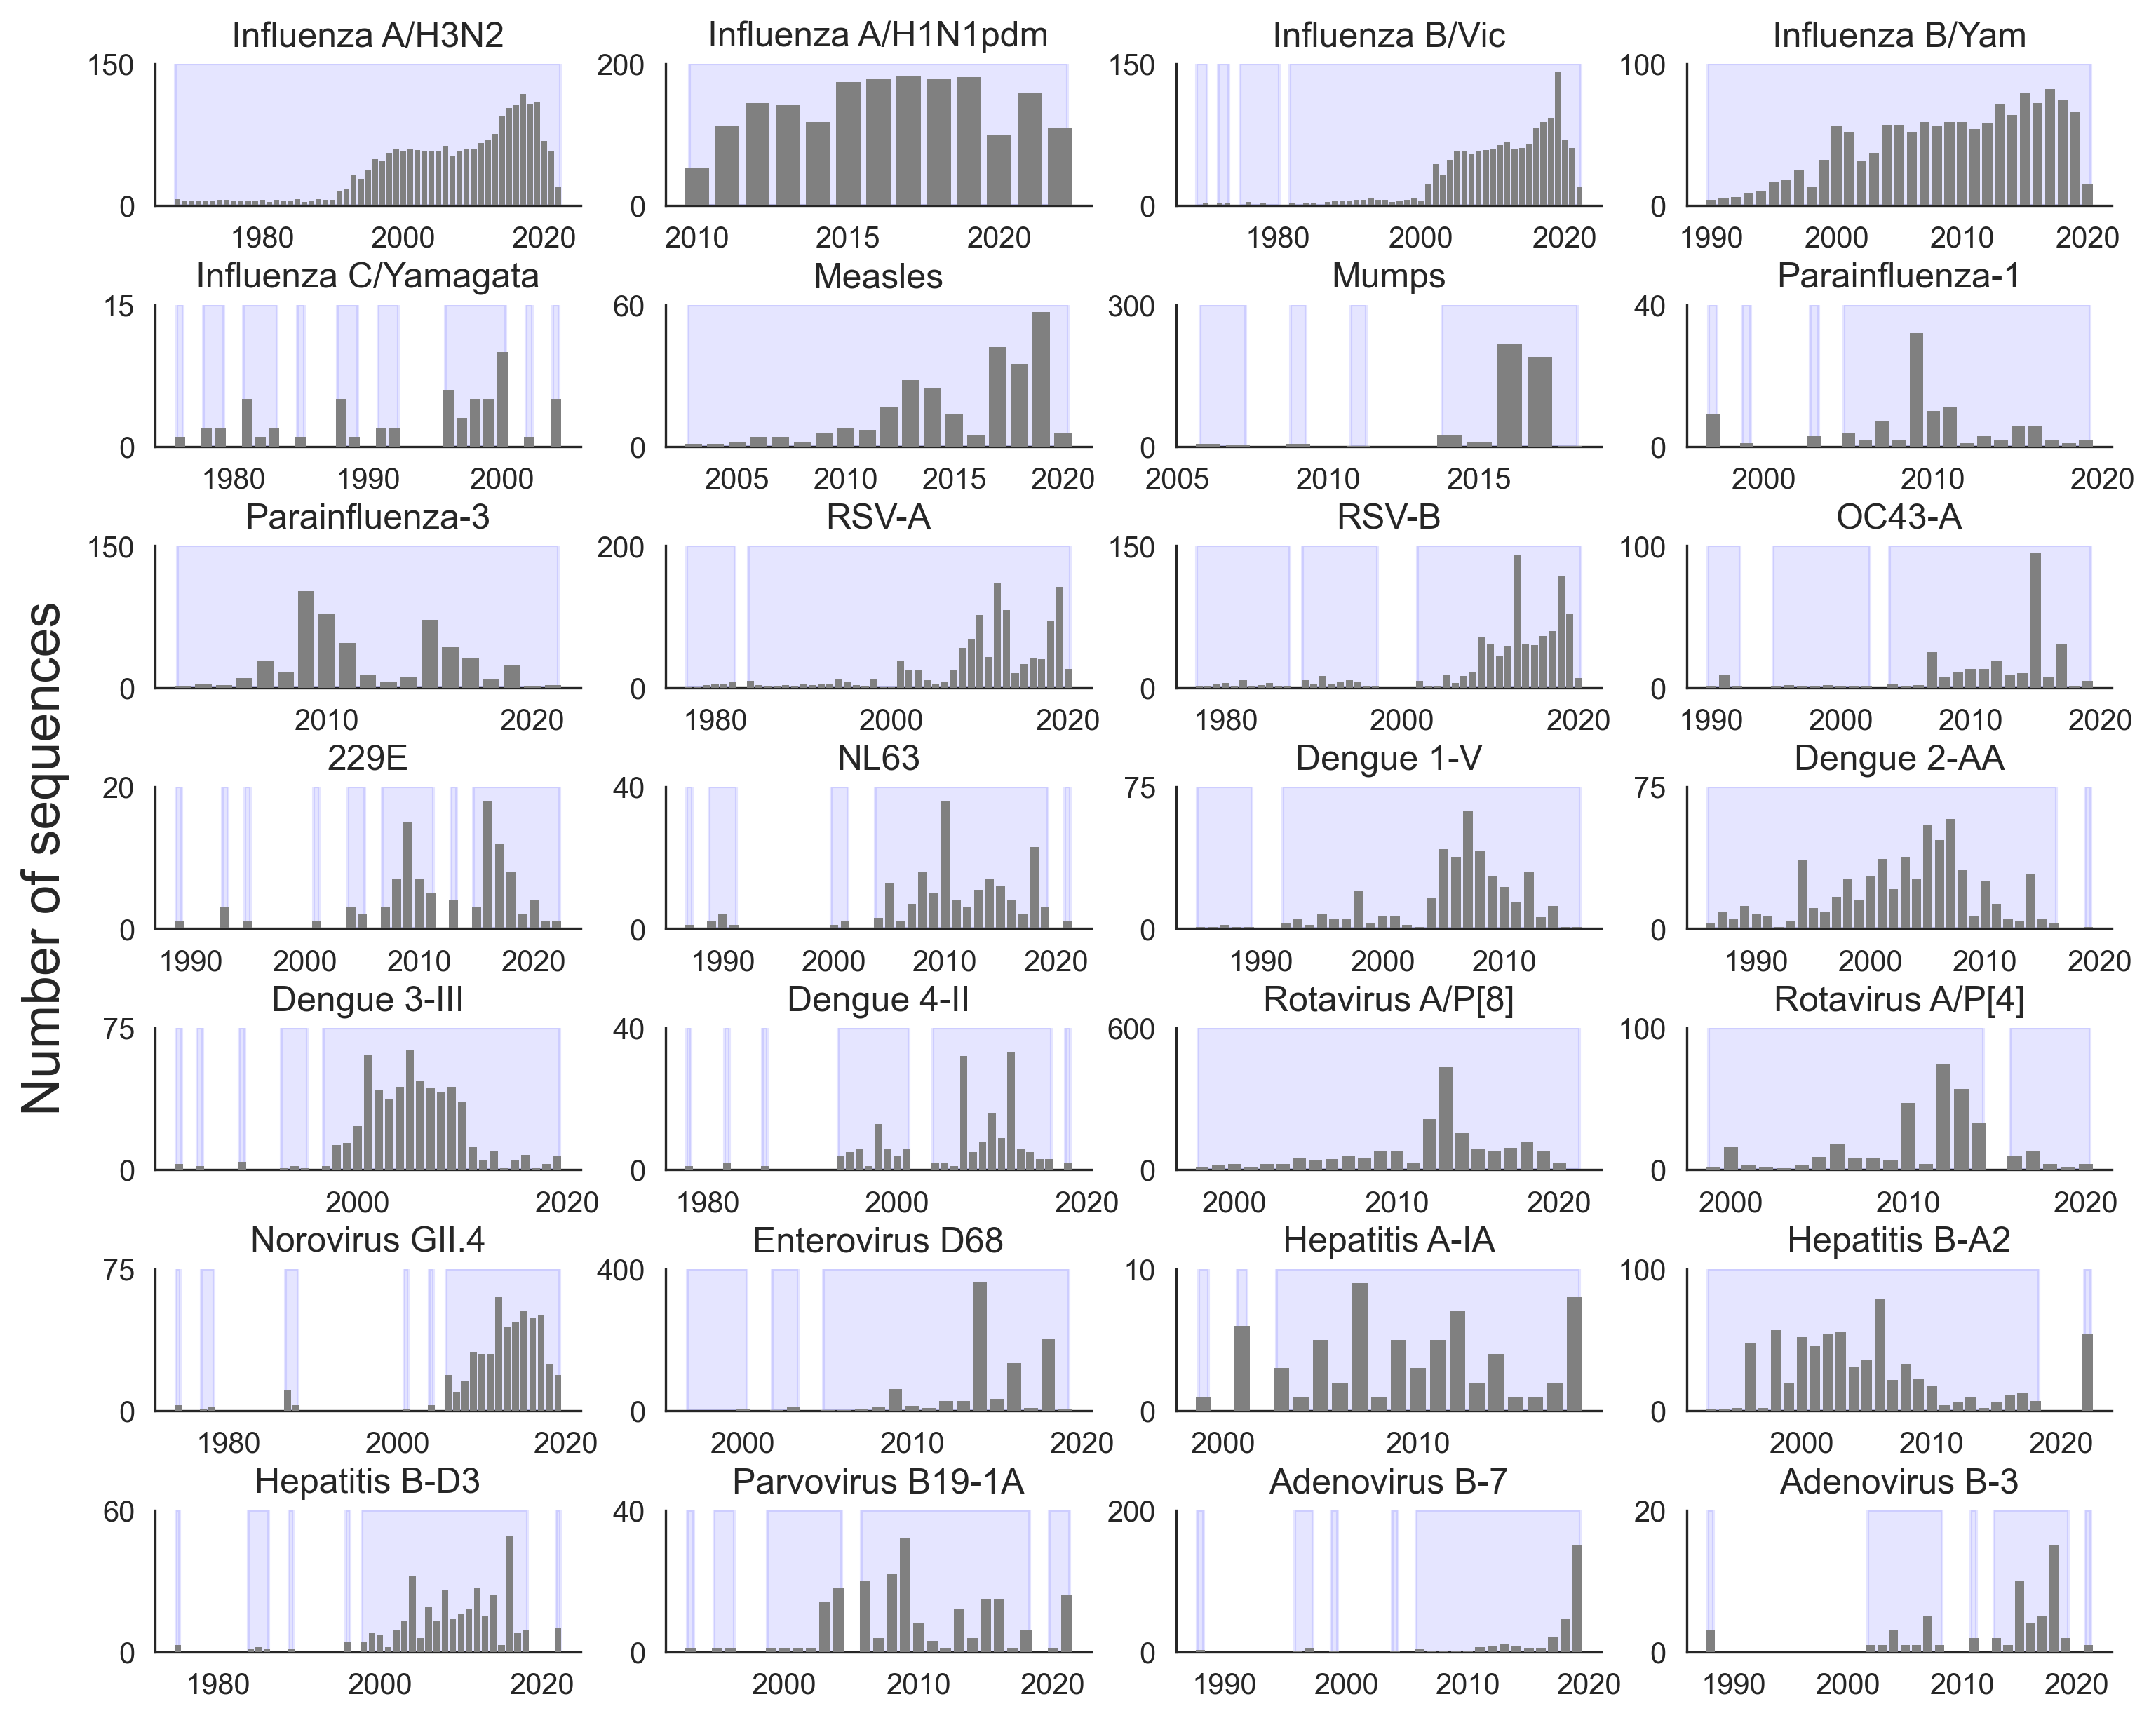

In [48]:
plot_absolute_count(filename='manuscript_figures/Supplement_SeqCounts.png')

In [9]:
def plot_seq_counts(filename=False):

    #plot styling
    sns.set_style("white")
    plt.rcParams['axes.labelsize'] = 18
    plt.rcParams['axes.labelweight'] = 'normal'
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['figure.dpi']= 300

    fig, axs = plt.subplots(7,4, figsize=(12,10), sharey=False, sharex=False)

    ax_mapper = [[row, col] for row in range(7) for col in range(4)]

    for i in range(len(all_viruses_legible)):
        v = all_viruses_legible[i]
        subset_df = df[df['virus']==v]
        min_year = subset_df['year'].min()
        max_year = subset_df['year'].max()
        ax_i = ax_mapper[i]

        sns.barplot(x='year', y='seq_count', data=subset_df, ax=axs[ax_i[0], ax_i[1]], color='#808080')

        axs[ax_i[0], ax_i[1]].set_yscale('log')


        axs[ax_i[0], ax_i[1]].set_xlabel('')
        if ax_i[0]==3 and ax_i[1]==0:
            axs[ax_i[0], ax_i[1]].set_ylabel('Number of sequences\n(log scale)')
            axs[ax_i[0], ax_i[1]].yaxis.set_label_coords(-0.2, 0.5)
        else:
            axs[ax_i[0], ax_i[1]].set_ylabel('')
        axs[ax_i[0], ax_i[1]].set_title(v)

        yticks = axs[ax_i[0], ax_i[1]].get_yticks()

        f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
        axs[ax_i[0], ax_i[1]].set_yticks([yticks[0], yticks[-1]], visible=True, rotation="horizontal")
        axs[ax_i[0], ax_i[1]].set_yticklabels(['', '${}$'.format(f.format_data(yticks[-1]))])

        xticks = axs[ax_i[0], ax_i[1]].get_xticks()
        axs[ax_i[0], ax_i[1]].set_xticks([xticks[0], xticks[-1]], visible=True, rotation="horizontal")



    plt.subplots_adjust(hspace=0.7)
    sns.despine()
    
    if filename:

        fig.savefig(filename, dpi=300, bbox_inches='tight', transparent=False, facecolor='white')

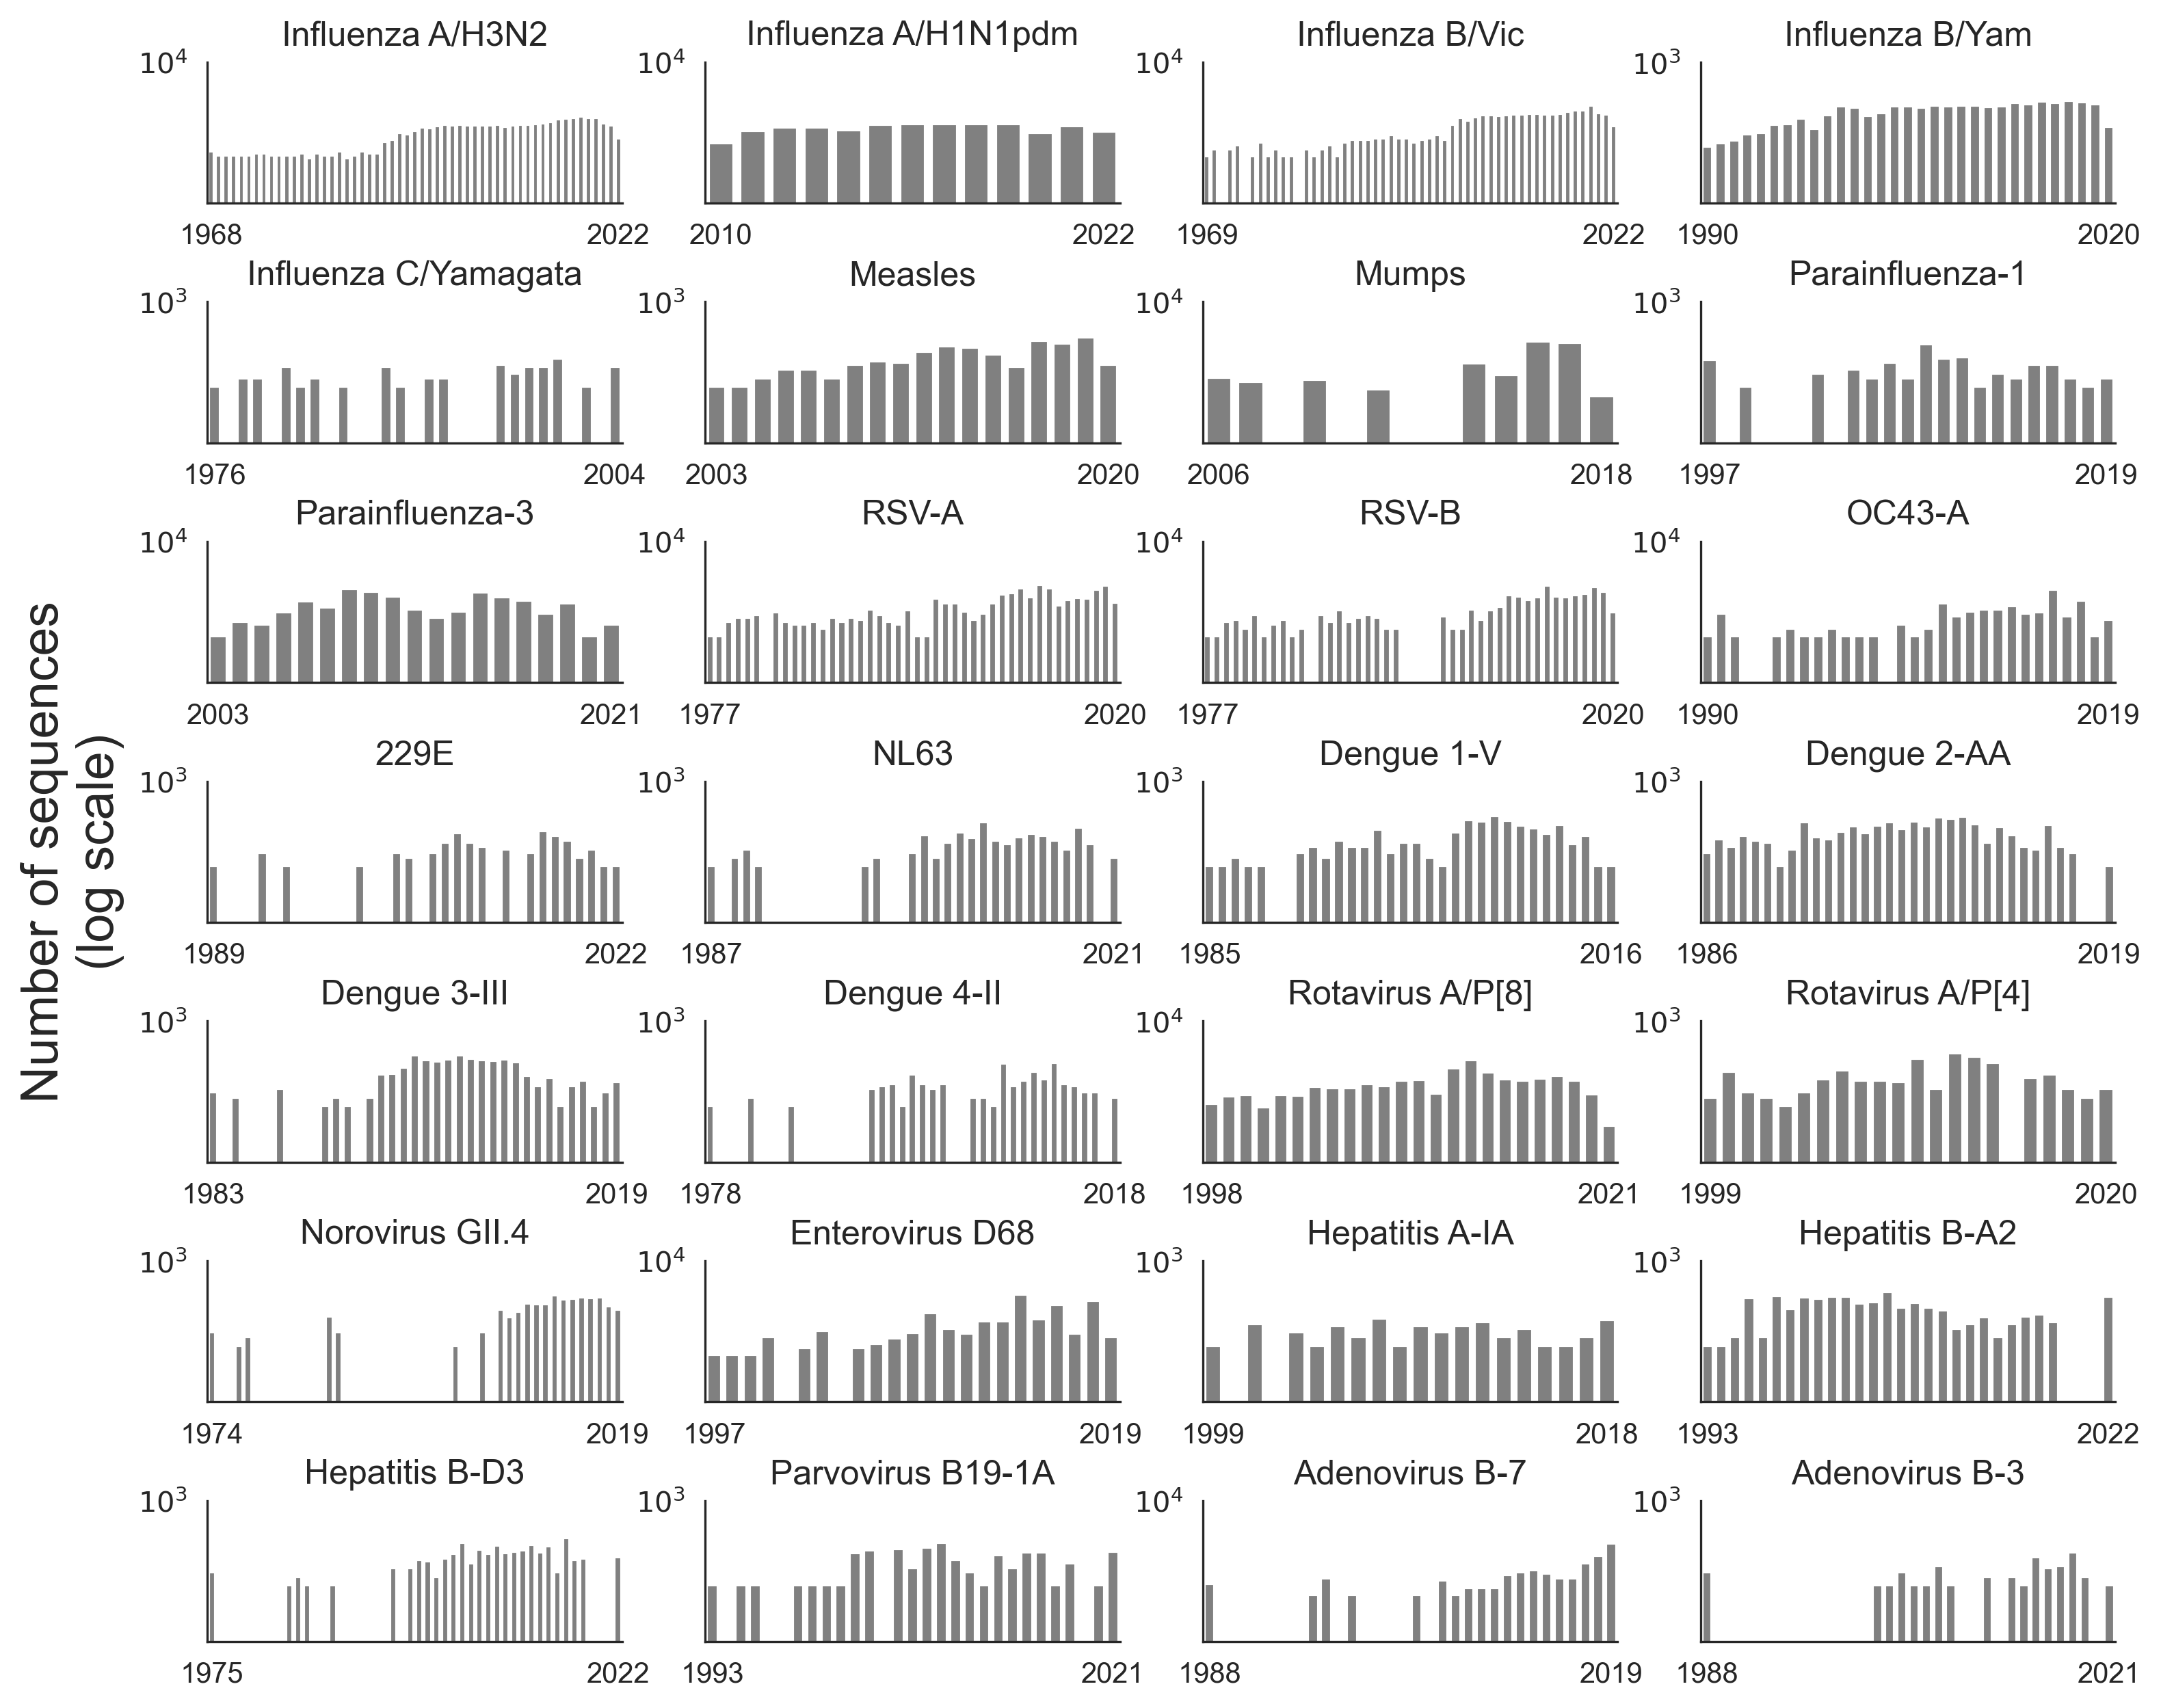

In [222]:
# plot_seq_counts(filename='manuscript_figures/Supplement_SeqCounts.png')

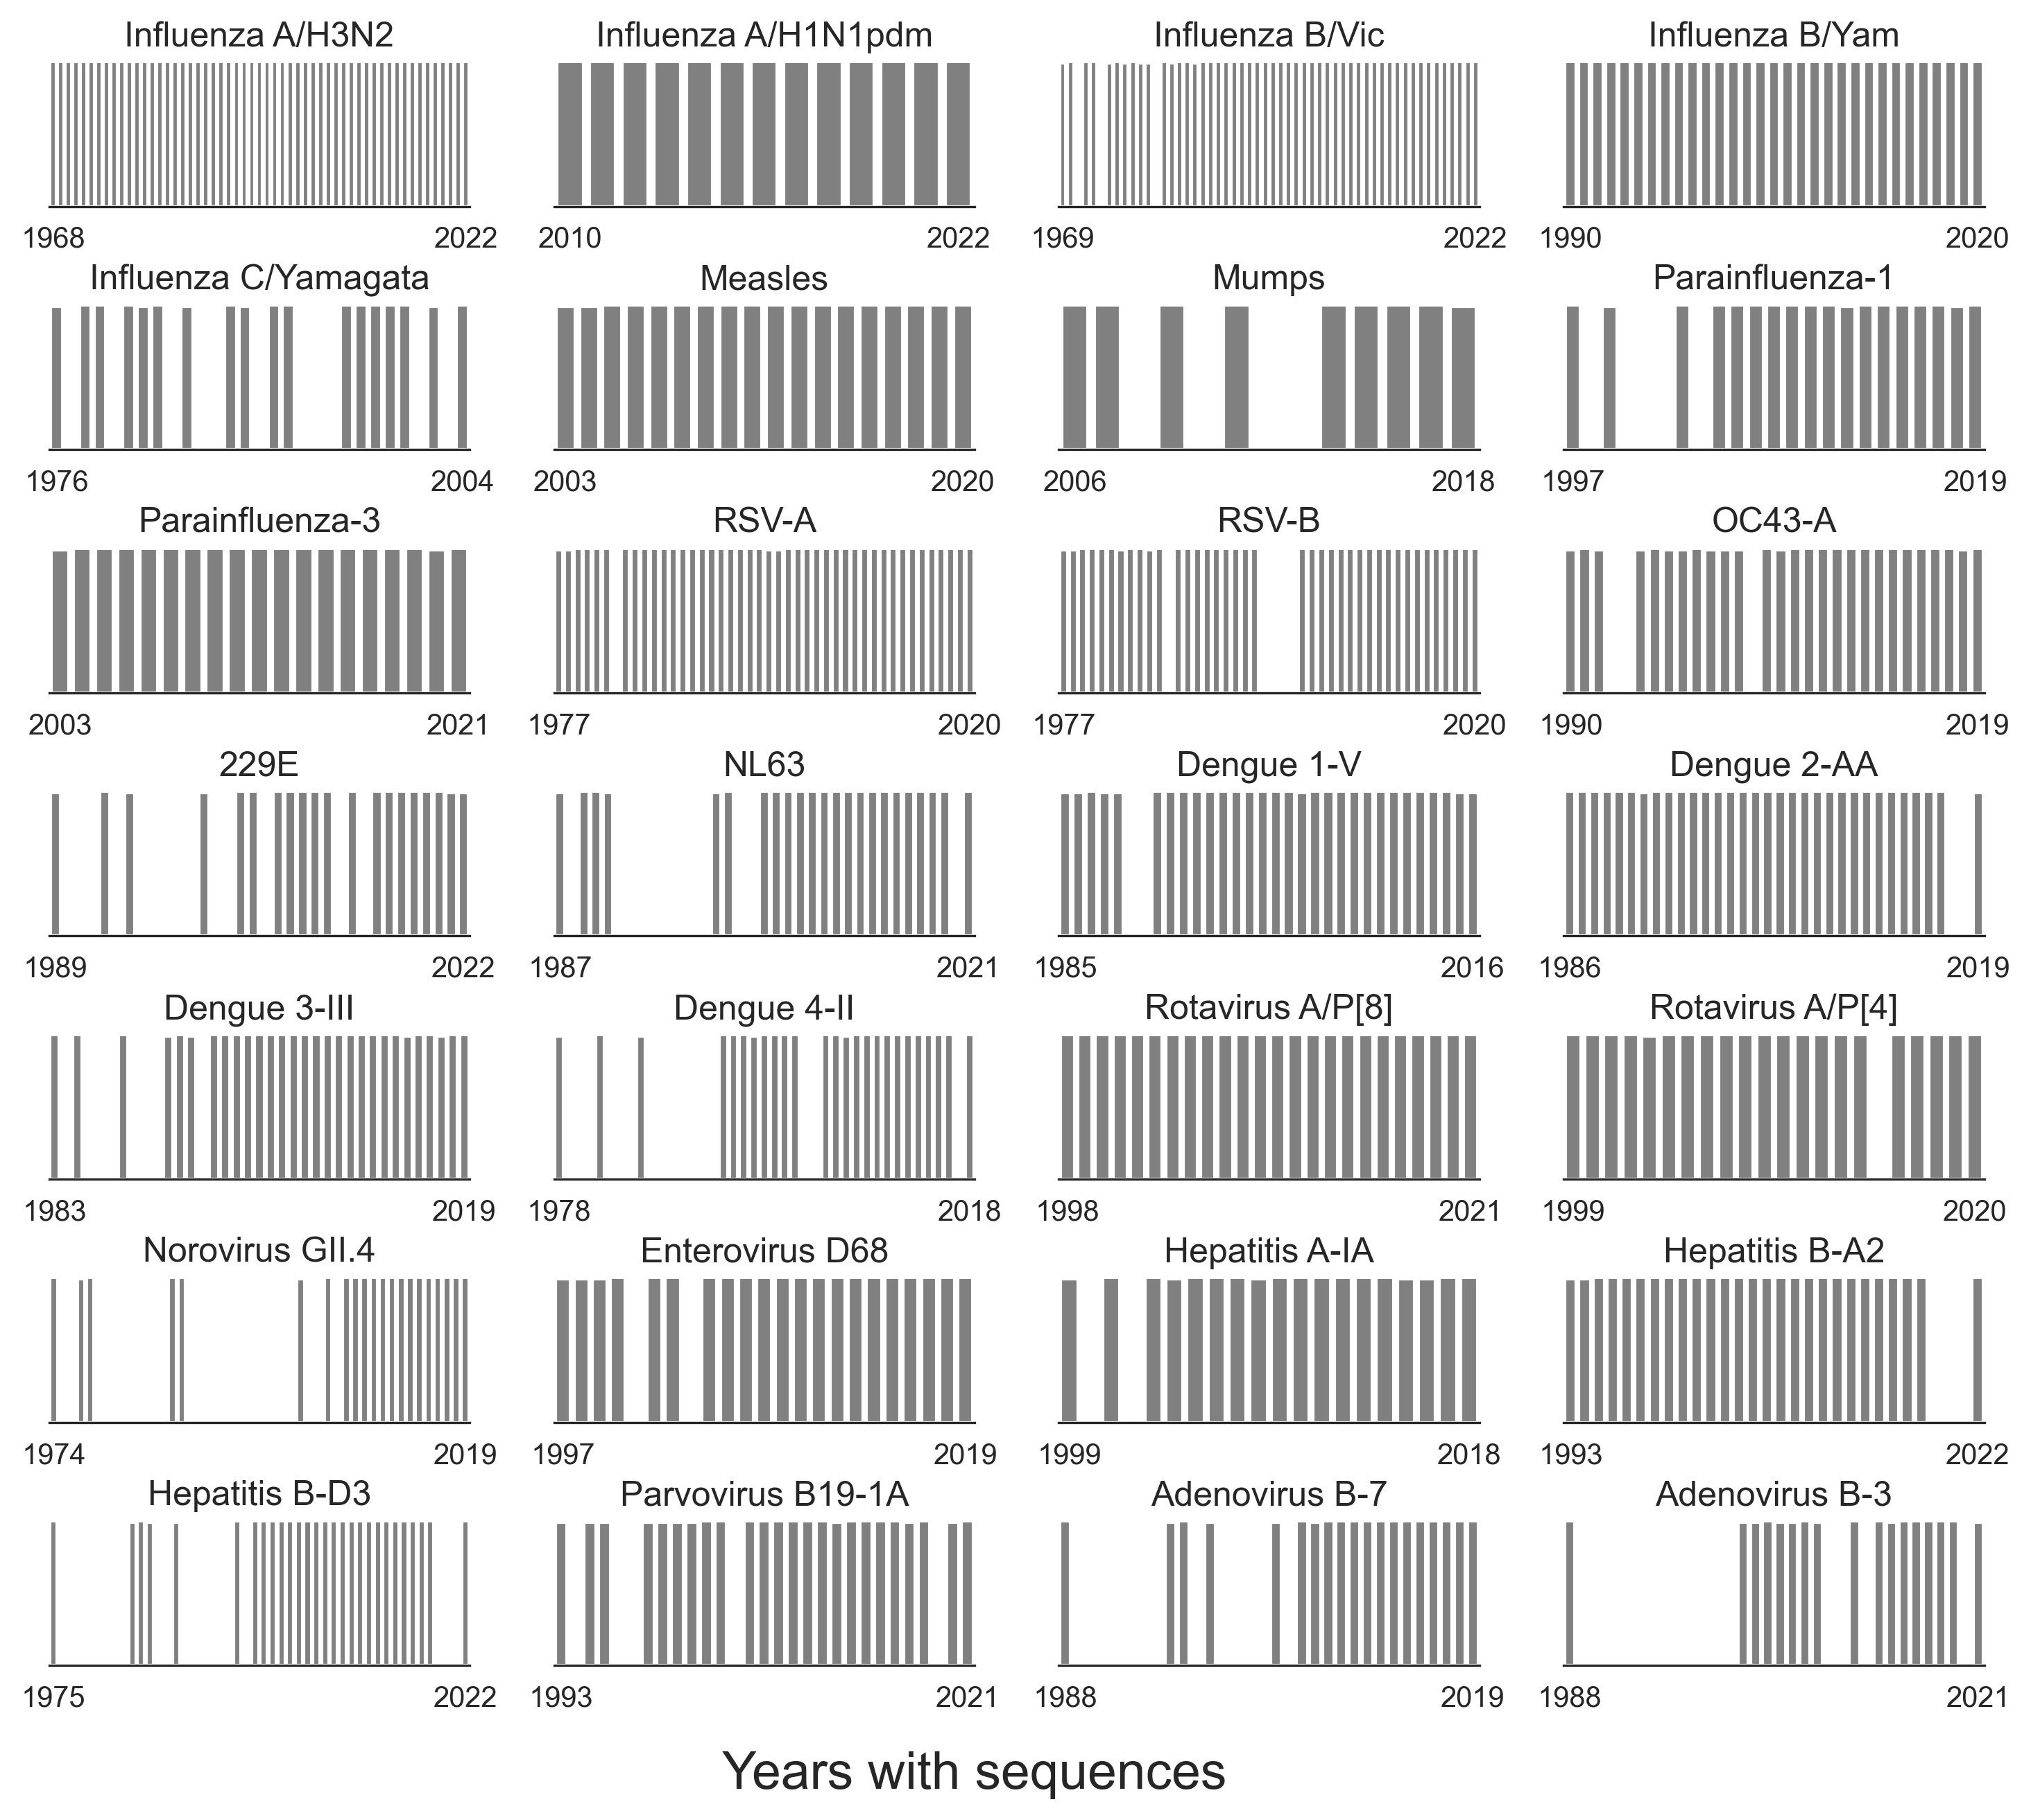

In [217]:
# rather than plotting sequence count, just plot bar if the year has sequences

#plot styling
sns.set_style("white")
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['figure.dpi']= 300

fig, axs = plt.subplots(7,4, figsize=(12,10), sharey=True, sharex=False)

ax_mapper = [[row, col] for row in range(7) for col in range(4)]

for i in range(len(all_viruses_legible)):
    v = all_viruses_legible[i]
    subset_df = df[df['virus']==v]
    min_year = subset_df['year'].min()
    max_year = subset_df['year'].max()
    ax_i = ax_mapper[i]
    
    sns.barplot(x='year', y='seq_count', data=subset_df, ax=axs[ax_i[0], ax_i[1]], color='#808080')
    
    axs[ax_i[0], ax_i[1]].set_ylim(0,1)
    if ax_i[0]==6 and ax_i[1]==1:
        axs[ax_i[0], ax_i[1]].set_xlabel('Years with sequences')
        axs[ax_i[0], ax_i[1]].xaxis.set_label_coords(1.0, -0.6)
    else:
        axs[ax_i[0], ax_i[1]].set_xlabel('')
    axs[ax_i[0], ax_i[1]].set_ylabel('')
    axs[ax_i[0], ax_i[1]].set_yticklabels([])
    axs[ax_i[0], ax_i[1]].set_title(v)
    axs[ax_i[0], ax_i[1]].tick_params(left = False)
    
    xticks = axs[ax_i[0], ax_i[1]].get_xticks()
    axs[ax_i[0], ax_i[1]].set_xticks([xticks[0], xticks[-1]], visible=True, rotation="horizontal")

    

plt.subplots_adjust(hspace=0.7)
sns.despine(left=True)